MCMC and Sparse MCMC in GPflow
--

*James Hensman, 2015-16*

In this notebook, we illustrate 'Exponential Regression'. The model is
$$ 
\theta \sim p(\theta)\\
f \sim \mathcal {GP}(0, k(x, x'; \theta))\\
f_i = f(x_i)\\
y_i \sim \mathcal {Exp} (e^{f_i})
$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$.

We fit two models. In the first, we do exact inference with MCMC. In the second, sparse infrence with MCMC.

In [1]:
import GPflow

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
X = np.linspace(-3,3,100)
Y = np.random.exponential(np.sin(X)**2)

In [3]:
#build the first model
k = GPflow.kernels.Matern32(1,ARD=False) + GPflow.kernels.Bias(1)
l = GPflow.likelihoods.Exponential()
m1 = GPflow.gpmc.GPMC(X[:,None], Y[:,None], k, l)

#build the second model
k = GPflow.kernels.Matern32(1,ARD=False) + GPflow.kernels.Bias(1)
l = GPflow.likelihoods.Exponential()
m2 = GPflow.sgpmc.SGPMC(X[:,None], Y[:,None], k, l, Z=X[::5,None])

for m in [m1, m2]:
    m.kern.matern32.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
    m.kern.matern32.variance.prior = GPflow.priors.Gamma(1.,1.)
    m.kern.bias.variance.prior = GPflow.priors.Gamma(1.,1.)
    


In [4]:
#Here are the two models
m1.kern

Name,values,prior,constriant
kern.bias.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.matern32.lengthscales,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.matern32.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve


In [5]:
m2.kern

Name,values,prior,constriant
kern.matern32.lengthscales,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.matern32.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve
kern.bias.variance,[ 1.],"Ga([ 1.],[ 1.])",+ve


In [6]:
for m in [m1, m2]:
    r = m.optimize()

compiling tensorflow function...
done
optimization terminated, setting model state
compiling tensorflow function...
done
optimization terminated, setting model state


In [7]:
#Now have a look at the kernel values
m1.kern

Name,values,prior,constriant
kern.bias.variance,[ 1.42231642],"Ga([ 1.],[ 1.])",+ve
kern.matern32.lengthscales,[ 0.04068888],"Ga([ 1.],[ 1.])",+ve
kern.matern32.variance,[ 13.1522575],"Ga([ 1.],[ 1.])",+ve


In [8]:
m2.kern

Name,values,prior,constriant
kern.matern32.lengthscales,[ 0.6415647],"Ga([ 1.],[ 1.])",+ve
kern.matern32.variance,[ 3.87498396],"Ga([ 1.],[ 1.])",+ve
kern.bias.variance,[ 1.08131793],"Ga([ 1.],[ 1.])",+ve


In [9]:
# run the sampler 
samples = (m1.sample(1000, verbose=1, epsilon = 0.08),
           m2.sample(1000, verbose=1, epsilon = 0.08))

Iteration:  100 	 Acc Rate:  83.0 %
Iteration:  200 	 Acc Rate:  74.0 %
Iteration:  300 	 Acc Rate:  80.0 %
Iteration:  400 	 Acc Rate:  87.0 %
Iteration:  500 	 Acc Rate:  88.0 %
Iteration:  600 	 Acc Rate:  87.0 %
Iteration:  700 	 Acc Rate:  89.0 %
Iteration:  800 	 Acc Rate:  89.0 %
Iteration:  900 	 Acc Rate:  90.0 %
Iteration:  1000 	 Acc Rate:  89.0 %
Iteration:  100 	 Acc Rate:  86.0 %
Iteration:  200 	 Acc Rate:  88.0 %
Iteration:  300 	 Acc Rate:  88.0 %
Iteration:  400 	 Acc Rate:  81.0 %
Iteration:  500 	 Acc Rate:  74.0 %
Iteration:  600 	 Acc Rate:  76.0 %
Iteration:  700 	 Acc Rate:  85.0 %
Iteration:  800 	 Acc Rate:  88.0 %
Iteration:  900 	 Acc Rate:  87.0 %
Iteration:  1000 	 Acc Rate:  57.0 %


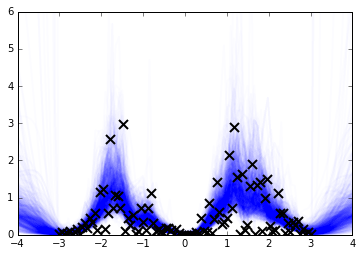

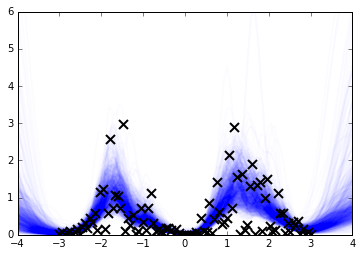

In [11]:
#make some predictions
for m, ss in zip([m1, m2], samples):
    plt.figure()
    xx = np.linspace(-4,4,100)[:,None]
    ys = []
    for s in ss:
        m.set_state(s)
        ys.append(m.predict_y(xx)[0])
        plt.plot(xx, ys[-1], 'b', alpha=0.01, lw=2)
    plt.plot(X, Y, 'kx', mew=2)
    plt.ylim(0, 6)

    
    

In [10]:
# VB for good measure

k = GPflow.kernels.Matern32(1,ARD=False) + GPflow.kernels.Bias(1)
l = GPflow.likelihoods.Exponential()
m3 = GPflow.vgp.VGP(X[:,None], Y[:,None], k, l)

In [11]:
m3.optimize()

compiling tensorflow function...
done
optimization terminated, setting model state


   status: 1
  success: False
     nfev: 1131
 hess_inv: <203x203 LbfgsInvHessProduct with dtype=float64>
      fun: array([-5.3408067])
        x: array([ 4.25872146,  0.19163224,  2.53814617, -0.34316603,  0.0874004 ,
       -0.07609333, -0.14453974,  0.06529401,  0.2375363 , -0.03786557,
       -0.62204484, -0.8410358 , -0.31928832,  0.88749193,  1.53548515,
        0.75375213, -0.24268197, -0.62647183, -0.63784733, -0.17388914,
        0.37588635,  0.27493797,  0.09602471, -0.08779887, -0.50905855,
       -0.64063368, -0.30001292,  0.34082957,  1.04420772,  0.691269  ,
       -0.05750738, -0.34607645, -0.38389305, -0.10278177,  0.07202685,
        0.08947044,  0.09567405, -0.13210521, -0.3252092 , -0.04086216,
        0.28356199,  0.28897287, -0.02675417, -0.30918723, -0.04705087,
        0.49057301,  0.58699578,  0.67855543,  0.49178104, -0.08414688,
       -0.72294317, -1.09743842, -1.04462856, -0.55744623,  0.08560996,
        0.32112966,  0.10564996, -0.44022185, -0.44089809,  

In [13]:
xx = np.linspace(-4,4,100)[:,None]
samples = m3.predict_f_samples(xx, 100)

(0, 6)

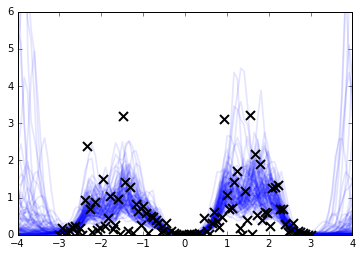

In [18]:
plt.plot(xx, np.exp(samples.squeeze()).T, 'b', alpha=0.1)
plt.plot(X, Y, 'kx', mew=2)
plt.ylim(0, 6)

In [16]:
samples.shape

(100, 100, 1)